In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, KFold, cross_validate, cross_val_predict
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import time
import seaborn as sns
import numpy as np 

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Read data

In [3]:
df = pd.read_excel("Dividend_payout_data_new.xlsx")
df.head()

,Symbol,Year,Dividend Payment,ROA,ROE,Free Cash Flow,leverage,Current ratio,Company Market Cap,Market to book ratio,Company age,Public age,Exchange Name,GICS Industry Name,Type
0,CHP.HM,2014,1,6.331501,15.175416,1.979882e+11,1.371418,1.747689,1.824000e+12,1.283550,17,11,HOCHIMINH STOCK EXCHANGE,Independent Power and Renewable Electricity Pr...,Utilities
1,POM.HM,2014,0,-0.338181,-1.214096,2.294292e+11,2.693567,1.332835,1.565064e+12,0.668879,22,11,HOCHIMINH STOCK EXCHANGE,Metals & Mining,Material
2,V21.HN,2014,0,0.123886,1.329525,5.200922e+09,9.778091,1.097540,8.840000e+09,0.296611,16,11,HANOI STOCK EXCHANGE,Construction & Engineering,Industrials
3,LIG.HN,2014,0,1.350044,9.561633,4.579653e+10,6.254353,1.132405,7.906702e+10,0.463967,25,11,HANOI STOCK EXCHANGE,Construction & Engineering,Industrials
4,MCC.HN,2014,1,16.401106,19.098559,-5.394960e+09,0.144151,8.078112,5.705109e+10,1.051306,15,11,HANOI STOCK EXCHANGE,Construction Materials,Material


In [4]:
# CREATE LISTS OF FEATURES THAT ARE CATEGORICAL OR NUMERICAL
Category_list = []
Numerical_list = []

for i in df.columns:
  if df[i].dtype == 'object':
    Category_list.append(i)
  else:
    Numerical_list.append(i)

print('Categorical list:', Category_list)
print('Numerical list :', Numerical_list)

Categorical list: ['Symbol', 'Exchange Name', 'GICS Industry Name', 'Type']
Numerical list : ['Year', 'Dividend Payment', 'ROA', 'ROE', 'Free Cash Flow', 'leverage ', 'Current ratio', 'Company Market Cap', 'Market to book ratio', 'Company age', 'Public age']


# Clean data

In [5]:
# Check missing value
missing_value = df.isna().sum()
missing_value

Symbol                     0
Year                       0
Dividend Payment           0
ROA                      376
ROE                      381
Free Cash Flow           386
leverage                 382
Current ratio            301
Company Market Cap       955
Market to book ratio    1023
Company age                0
Public age                 0
Exchange Name              0
GICS Industry Name         0
Type                       0
dtype: int64

,Total,Percent
Market to book ratio,1023,0.178596
Company Market Cap,955,0.166725
Free Cash Flow,386,0.067388
leverage,382,0.066690
ROE,381,0.066515
ROA,376,0.065642
Current ratio,301,0.052549
Symbol,0,0.000000
Year,0,0.000000
Dividend Payment,0,0.000000


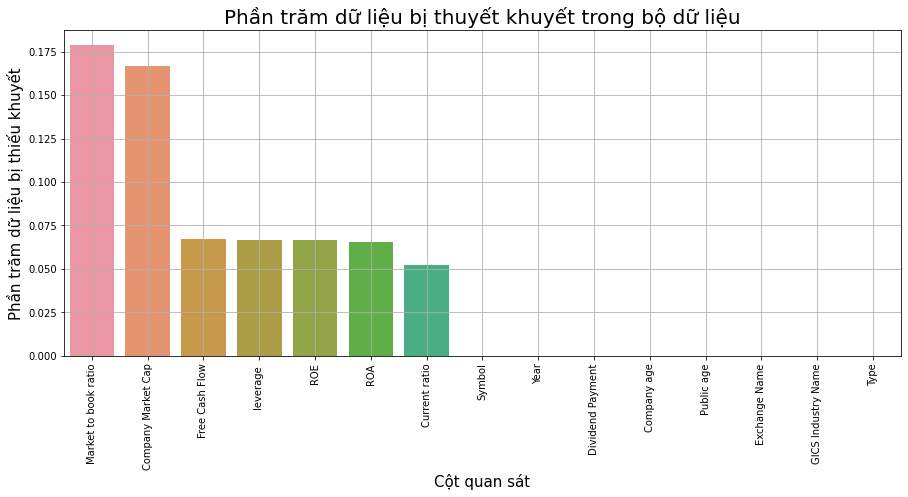

In [6]:
# Phần trăm bị thiếu khuyết
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
# phần trăm khuyết = số lượng khuyết / tổng số dòng.
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

# Visualization missing data
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Cột quan sát', fontsize=15)
plt.ylabel('Phần trăm dữ liệu bị thiếu khuyết', fontsize=15)
plt.title('Phần trăm dữ liệu bị thuyết khuyết trong bộ dữ liệu', fontsize=20)
plt.grid()
missing_data

In [7]:
#Thay thế các missing value bằng giá trị trung bình
df['ROA'].fillna(df['ROA'].median(), inplace=True)
df['ROE'].fillna(df['ROE'].median(), inplace=True)
df['Free Cash Flow'].fillna(df['Free Cash Flow'].median(), inplace=True)
df['leverage '].fillna(df['leverage '].median(), inplace=True)
df['Current ratio'].fillna(df['Current ratio'].median(), inplace=True)
df['Company Market Cap'].fillna(df['Company Market Cap'].median(), inplace=True)
df['Market to book ratio'].fillna(df['Market to book ratio'].median(), inplace=True)

In [8]:
df.isnull().sum()

Symbol                  0
Year                    0
Dividend Payment        0
ROA                     0
ROE                     0
Free Cash Flow          0
leverage                0
Current ratio           0
Company Market Cap      0
Market to book ratio    0
Company age             0
Public age              0
Exchange Name           0
GICS Industry Name      0
Type                    0
dtype: int64

In [9]:
df.shape

(5728, 15)

In [10]:
#Check trùng lặp
df.duplicated().sum()

0

In [11]:
# Chia 2 dataframe HANOI va HOCHIMINH
hcm_df = df[df['Exchange Name'] == 'HOCHIMINH STOCK EXCHANGE']
hcm_df.head()

,Symbol,Year,Dividend Payment,ROA,ROE,Free Cash Flow,leverage,Current ratio,Company Market Cap,Market to book ratio,Company age,Public age,Exchange Name,GICS Industry Name,Type
0,CHP.HM,2014,1,6.331501,15.175416,1.979882e+11,1.371418,1.747689,1.824000e+12,1.283550,17,11,HOCHIMINH STOCK EXCHANGE,Independent Power and Renewable Electricity Pr...,Utilities
1,POM.HM,2014,0,-0.338181,-1.214096,2.294292e+11,2.693567,1.332835,1.565064e+12,0.668879,22,11,HOCHIMINH STOCK EXCHANGE,Metals & Mining,Material
8,TDC.HM,2014,1,2.117383,9.128581,-7.003307e+10,3.502852,1.230785,1.060000e+12,0.904672,19,11,HOCHIMINH STOCK EXCHANGE,Real Estate Management & Development,Real_estate
9,OGC.HM,2014,0,3.494976,12.075328,2.352934e+11,2.444987,1.413118,2.130000e+12,0.609985,14,11,HOCHIMINH STOCK EXCHANGE,Diversified Financial Services,Financials
11,NVT.HM,2014,0,1.579775,0.666014,-4.607846e+10,0.172792,2.439862,4.706000e+11,0.556663,15,11,HOCHIMINH STOCK EXCHANGE,Real Estate Management & Development,Real_estate


In [12]:
hn_df = df[df['Exchange Name'] == 'HANOI STOCK EXCHANGE']
hn_df.head()

,Symbol,Year,Dividend Payment,ROA,ROE,Free Cash Flow,leverage,Current ratio,Company Market Cap,Market to book ratio,Company age,Public age,Exchange Name,GICS Industry Name,Type
2,V21.HN,2014,0,0.123886,1.329525,5.200922e+09,9.778091,1.097540,8.840000e+09,0.296611,16,11,HANOI STOCK EXCHANGE,Construction & Engineering,Industrials
3,LIG.HN,2014,0,1.350044,9.561633,4.579653e+10,6.254353,1.132405,7.906702e+10,0.463967,25,11,HANOI STOCK EXCHANGE,Construction & Engineering,Industrials
4,MCC.HN,2014,1,16.401106,19.098559,-5.394960e+09,0.144151,8.078112,5.705109e+10,1.051306,15,11,HANOI STOCK EXCHANGE,Construction Materials,Material
5,TET.HN,2014,1,19.792376,24.731273,9.209246e+09,0.213317,5.857647,1.112073e+11,1.513489,51,11,HANOI STOCK EXCHANGE,"Textiles, Apparel & Luxury Goods",Consumer_discretionary
6,KSD.HN,2014,0,1.746610,2.404545,4.658953e+09,0.427322,3.221673,6.360000e+10,0.779815,18,11,HANOI STOCK EXCHANGE,Construction Materials,Material


In [13]:
a = df[['ROA', 'ROE', 'Free Cash Flow',
       'leverage ', 'Current ratio', 'Company Market Cap',
       'Market to book ratio', 'Company age', 'Public age']]

In [14]:
hcm_df_test = hcm_df
hn_df_test = hn_df

In [15]:
#Tìm outliers
def detect_outliers(df):
    # Tính mean và standard deviation của X
    mean = np.mean(df)
    std = np.std(df)

    # Tính giá trị lower và upper threshold
    lower_threshold = mean - 3 * std
    upper_threshold = mean + 3 * std

    # Tìm các giá trị ngoài phạm vi lower và upper threshold
    outliers = [df for df in df if df < lower_threshold or df > upper_threshold]

    return outliers
#Xóa outliers
print('Number of rows before removing outliers of HCM Exhange Stock:', len(hcm_df))
for col in a.columns:
    outliers1 = detect_outliers(hcm_df[col])
    hcm_df = hcm_df[~hcm_df[col].isin(outliers1)]

print('Number of rows after removing outliers:', len(hcm_df))
print(f'Dữ liệu còn lại sau khi lấy outlier là {(hcm_df.shape[0] / hcm_df_test.shape[0]) * 100} %')


print('Number of rows before removing outliers of HN Exchange Stock:', len(hn_df))
for col in a.columns:
    outliers2 = detect_outliers(hn_df[col])
    hn_df = hn_df[~hn_df[col].isin(outliers2)]
print('Number of rows after removing outliers:', len(hn_df))
print(f'Dữ liệu còn lại sau khi lấy outlier là {(hn_df.shape[0] / hn_df_test.shape[0]) * 100} %')



Number of rows before removing outliers of HCM Exhange Stock: 3136
Number of rows after removing outliers: 2825
Dữ liệu còn lại sau khi lấy outlier là 90.0829081632653 %
Number of rows before removing outliers of HN Exchange Stock: 2592
Number of rows after removing outliers: 2343
Dữ liệu còn lại sau khi lấy outlier là 90.39351851851852 %


## Mức độ tương quan

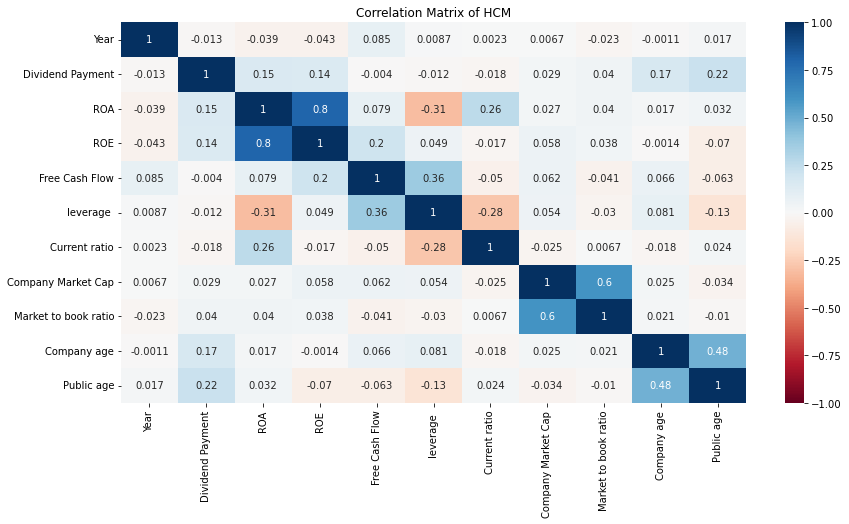

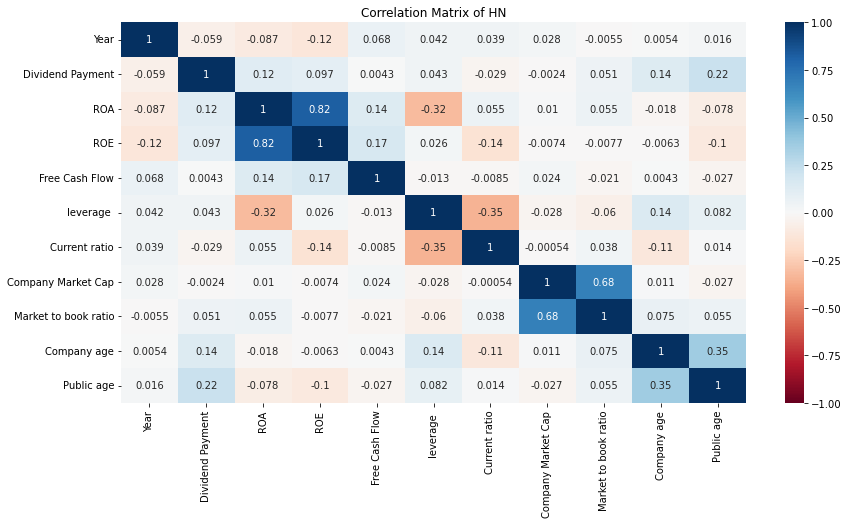

In [16]:
plt.figure(figsize=(14,7))
sns.heatmap(hcm_df.corr(), annot=True, cmap='RdBu', vmin=-1, vmax=1)
plt.title('Correlation Matrix of HCM')
plt.show()

plt.figure(figsize=(14,7))
sns.heatmap(hn_df.corr(), annot=True, cmap='RdBu', vmin=-1, vmax=1)
plt.title('Correlation Matrix of HN')
plt.show()

# Trực quan hóa dữ liệu

## Categorical data

## Loại hình doanh nghiệp, thành phố nào sẽ đảm bảo về khả năng chi trả cổ tức?

In [17]:
categorical = df[['Exchange Name','GICS Industry Name','Type']]

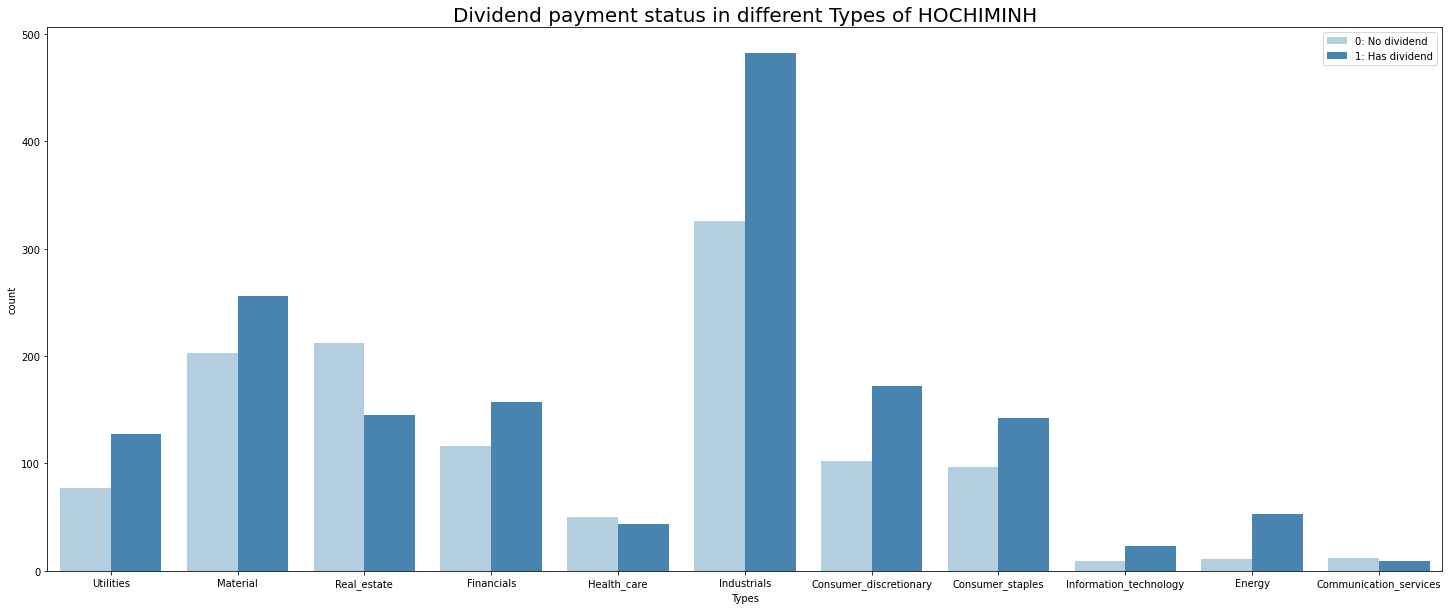

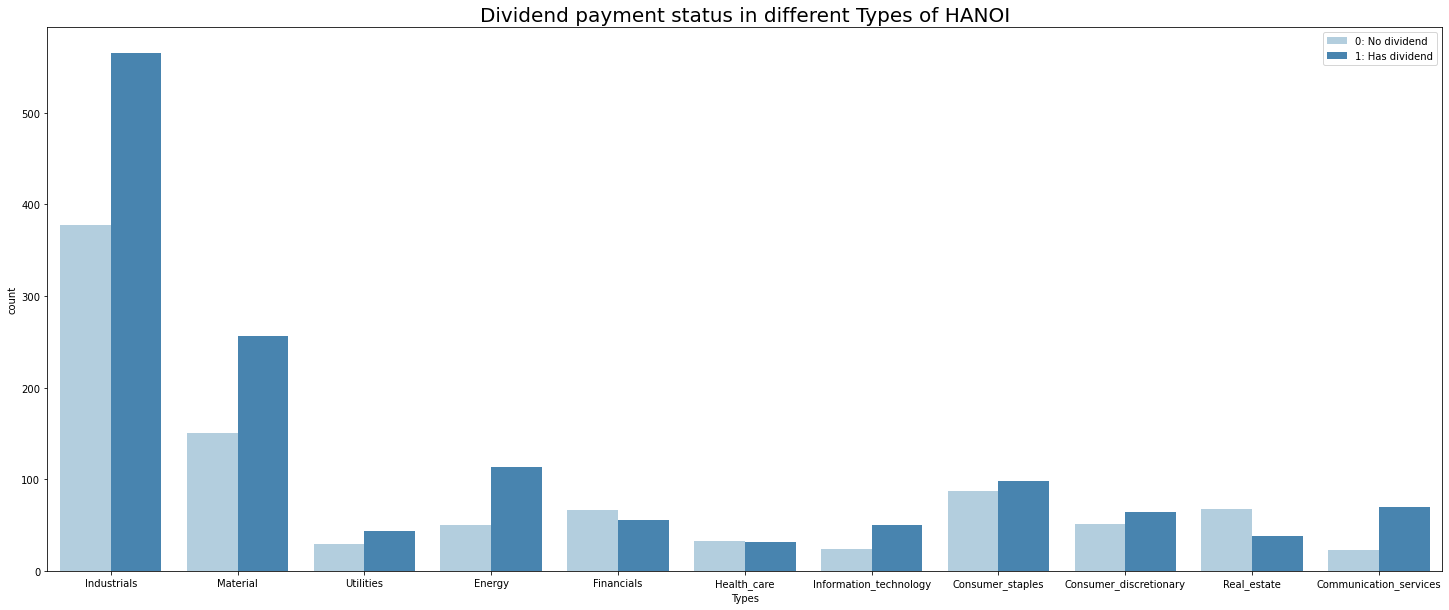

In [18]:
plt.figure(figsize=(25,10))
ax1= sns.countplot(x = 'Type', hue = 'Dividend Payment',data = hcm_df, palette = 'Blues')
legend_labels,_ = ax1. get_legend_handles_labels()
plt.title('Dividend payment status in different Types of HOCHIMINH',size = 20)
plt.xlabel('Types')
plt.legend(['0: No dividend','1: Has dividend'])

plt.figure(figsize=(25,10))
ax1= sns.countplot(x = 'Type', hue = 'Dividend Payment',data = hn_df, palette = 'Blues')
legend_labels,_ = ax1. get_legend_handles_labels()
plt.title('Dividend payment status in different Types of HANOI',size = 20)
plt.xlabel('Types')
plt.legend(['0: No dividend','1: Has dividend'])

- Ở HCM, tỷ lệ chi trả cổ tức của ngành Energy là cao nhất, thấp nhất là Real_estate
- Ở HN, tỷ lệ chi trả cổ tức của ngành Communication_services là cao nhất, thấp nhất vẫn là Real_estate
- Vì vậỵ chúng ta sẽ đi tìm hiểu lợi nhuận mà các doanh nghiệp theo những ngành đó đạt được để từ đó ra quyết định có chi trả cổ tức hay không? Liệu Business Model có ảnh hưởng đến quyết định này? Nếu không chi trả cổ tức thì nó sẽ chi trả theo con đường nào?

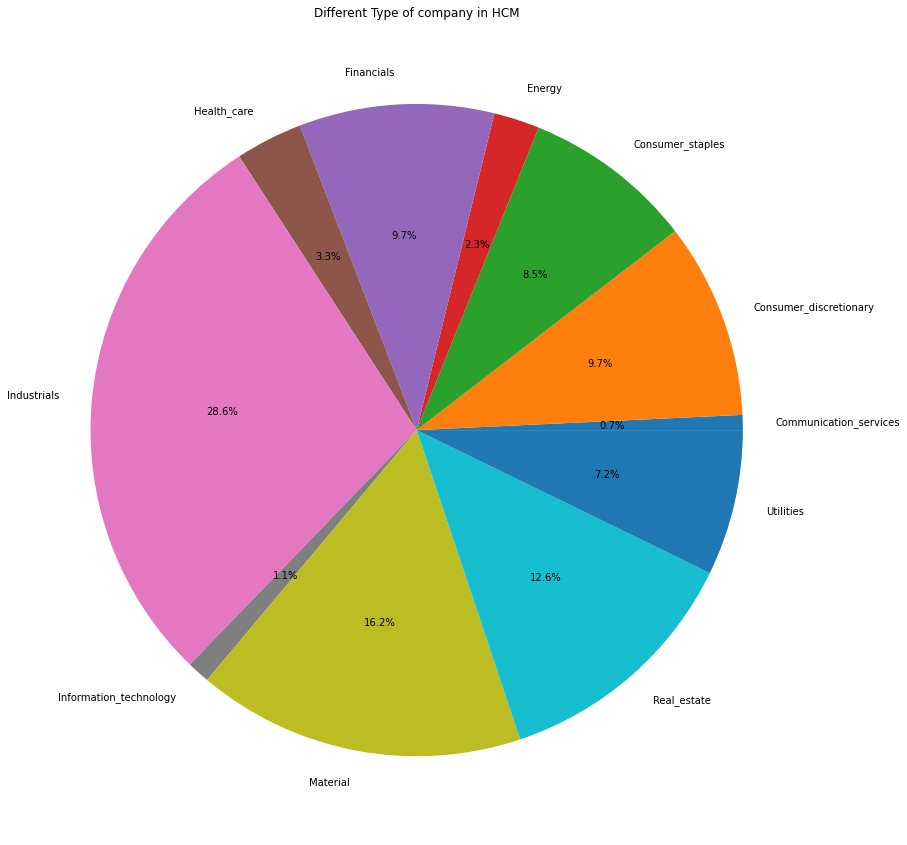

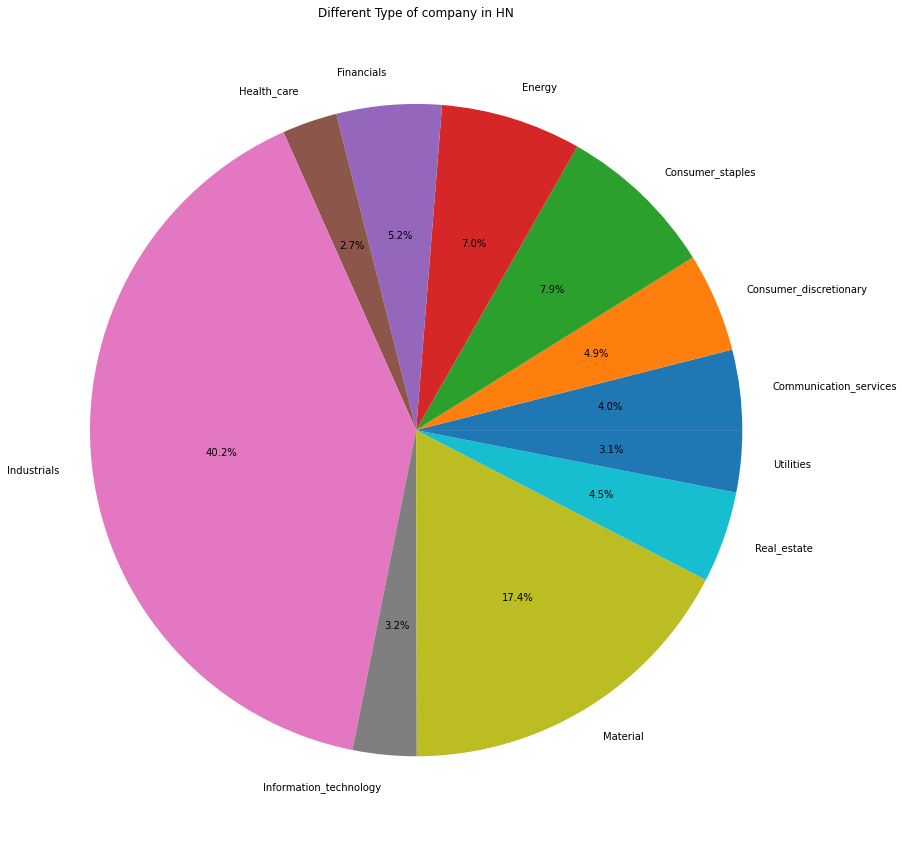

In [19]:
groups=hcm_df.groupby('Type')
counts=groups.size()
plt.figure(figsize=(30, 15))
plt.pie(counts.values, labels=counts.index, autopct='%1.1f%%')
plt.title("Different Type of company in HCM")
plt.show()

groups=hn_df.groupby('Type')
counts=groups.size()
plt.figure(figsize=(30, 15))
plt.pie(counts.values, labels=counts.index, autopct='%1.1f%%')
plt.title("Different Type of company in HN")
plt.show()

- Ở HN và HCM thì số lượng doanh nghiệp trong ngành Industrials chiếm nhiều nhất, tuy nhiên số lượng doanh nghiệp Industrials ở HN chiếm tỉ lệ nhiều hơn ở HCM (40,2% > 28,6%). 
- Ở HCM thì số doanh nghiệp của ngành Communication Services chiếm số lượng ít nhất, trong khi đó ở HN, doanh nghiệp có số lượng ít nhất là của ngành Health Care.

## Numerical data

In [20]:
numerical_hcm = hcm_df[['Dividend Payment','ROA', 'ROE', 'Free Cash Flow',
       'leverage ', 'Current ratio', 'Company Market Cap',
       'Market to book ratio', 'Company age', 'Public age']]
numerical_hn = hn_df[['Dividend Payment','ROA', 'ROE', 'Free Cash Flow',
       'leverage ', 'Current ratio', 'Company Market Cap',
       'Market to book ratio', 'Company age', 'Public age']]

In [21]:
numerical_hcm.describe()

,Dividend Payment,ROA,ROE,Free Cash Flow,leverage,Current ratio,Company Market Cap,Market to book ratio,Company age,Public age
count,2825.000000,2825.000000,2825.000000,2.825000e+03,2825.000000,2825.000000,2.825000e+03,2825.000000,2825.000000,2825.000000
mean,0.569912,6.203004,12.024683,1.393001e+11,1.631119,2.764467,1.655211e+12,2.411975,18.541239,8.765664
std,0.495176,5.607986,9.327606,7.771203e+11,2.284703,3.063031,5.315603e+12,8.030628,6.627681,5.318232
min,0.000000,-15.449094,-23.874582,-5.865636e+12,-4.530900,0.831393,8.750000e+09,-18.796886,4.000000,-1.000000
25%,0.000000,2.442330,6.226361,-3.171729e+09,0.534332,1.496192,1.936805e+11,0.242814,14.000000,4.000000
50%,1.000000,4.639190,10.062871,2.011110e+10,0.974908,1.913989,3.374864e+11,0.862543,17.000000,11.000000
75%,1.000000,8.707463,16.995085,1.078636e+11,1.767542,2.720038,9.359675e+11,1.125067,22.000000,13.000000
max,1.000000,29.564530,48.124764,6.248840e+12,17.645072,33.879421,6.625719e+13,100.086138,41.000000,21.000000


In [22]:
numerical_hn.describe()

,Dividend Payment,ROA,ROE,Free Cash Flow,leverage,Current ratio,Company Market Cap,Market to book ratio,Company age,Public age
count,2343.000000,2343.000000,2343.000000,2.343000e+03,2343.000000,2343.000000,2.343000e+03,2343.000000,2343.000000,2343.000000
mean,0.590696,5.282778,9.850368,1.044890e+10,1.417176,3.401971,1.428797e+12,11.045466,18.856594,10.114383
std,0.491810,5.245427,8.527963,7.063742e+10,1.556830,4.501478,4.812030e+12,39.216340,6.393508,4.133415
min,0.000000,-14.533143,-22.049165,-4.553403e+11,-8.350709,0.854711,3.300000e+09,-24.329050,2.000000,0.000000
25%,0.000000,1.641969,4.103509,-1.591000e+09,0.426294,1.478369,9.608009e+10,0.558311,14.000000,7.000000
50%,1.000000,4.608963,9.428815,5.541125e+09,0.974908,1.913989,3.253250e+11,0.862543,18.000000,11.000000
75%,1.000000,7.790222,14.095753,1.674071e+10,1.886086,3.155642,6.458713e+11,3.780742,22.000000,13.000000
max,1.000000,27.109486,41.856372,4.980573e+11,11.371812,43.113157,6.848492e+13,466.118816,40.000000,20.000000


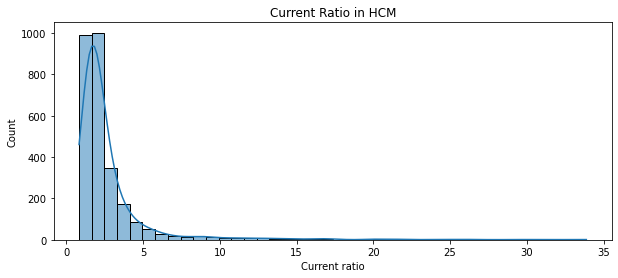

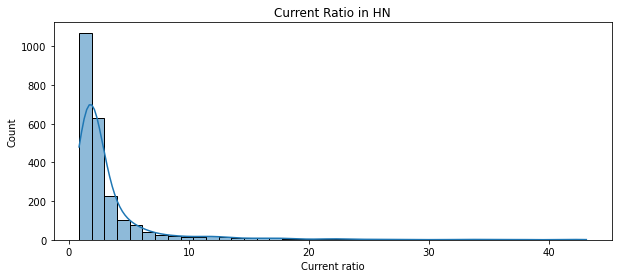

In [23]:
plt.figure(figsize=(10,4))
sns.histplot(data=hcm_df,x='Current ratio', bins=40, kde=True)
plt.title('Current Ratio in HCM')
plt.show()
plt.figure(figsize=(10,4))
sns.histplot(data=hn_df,x='Current ratio',bins=40, kde=True)
plt.title('Current Ratio in HN')
plt.show()

- Nhìn vào hai biểu đồ ta thấy current ratio của HCM Stock Exchange cao hơn so với HN Stock Exchange. Như vậy nhiều doanh nghiệp ở HCM có khả năng thanh toán, trả nợ tốt hơn so với các doanh nghiệp ở HN.

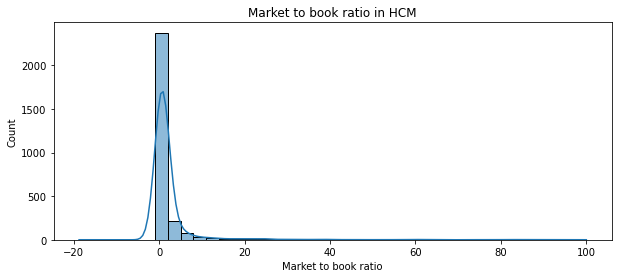

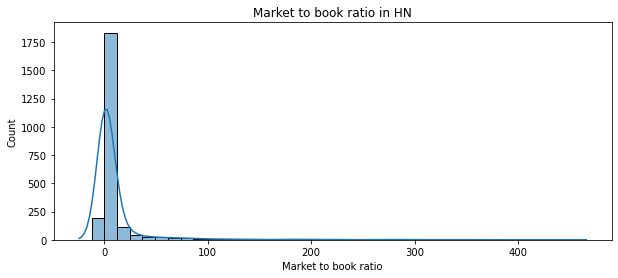

In [24]:
plt.figure(figsize=(10,4))
sns.histplot(data=hcm_df,x='Market to book ratio', bins=40, kde=True)
plt.title('Market to book ratio in HCM')
plt.show()
plt.figure(figsize=(10,4))
sns.histplot(data=hn_df,x='Market to book ratio',bins=40, kde=True)
plt.title('Market to book ratio in HN')
plt.show()

- Nhìn vào biểu đồ ta thấy được ở HCM có nhiều công ty được định giá cao trên thị trường tài chính hơn là ở HN.

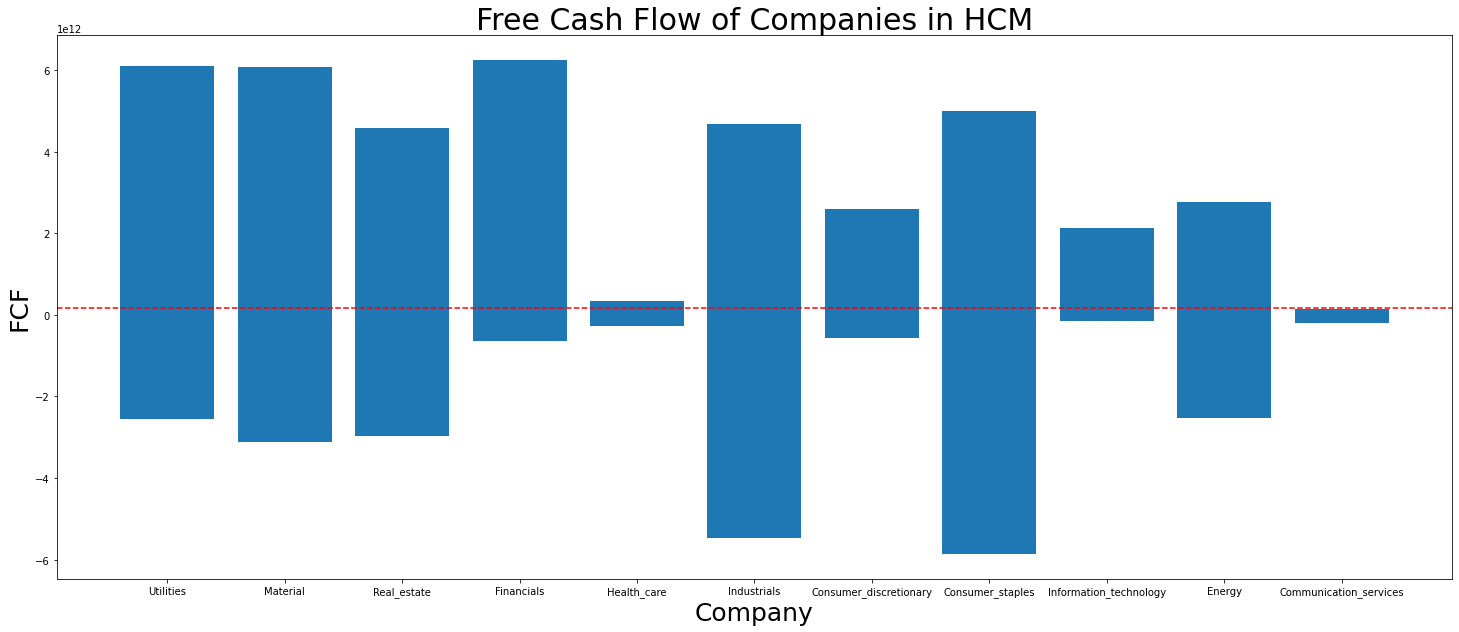

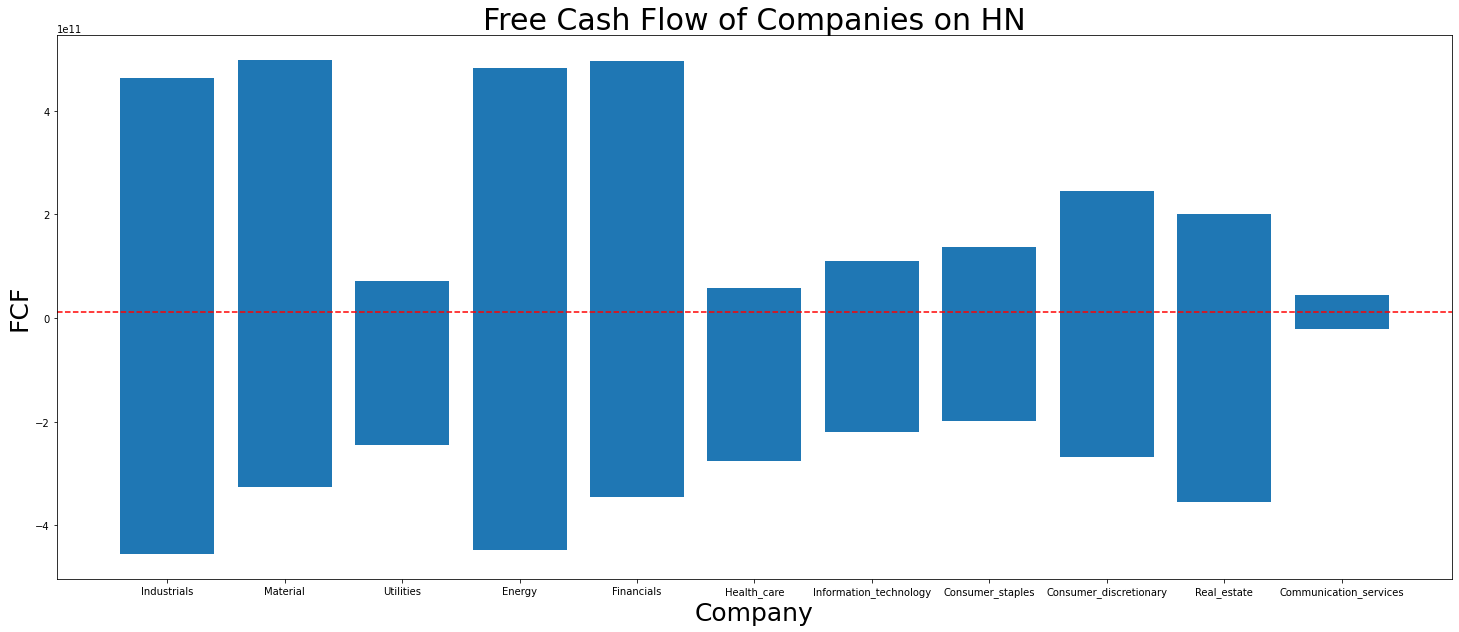

In [25]:
hcm_fcf_mean_by_type=hcm_df.groupby('Type')['Free Cash Flow'].mean()
plt.figure(figsize=(25,10))
plt.bar(hcm_df['Type'], hcm_df['Free Cash Flow'])
plt.title('Free Cash Flow of Companies in HCM', fontsize=30)
plt.xlabel('Company', fontsize=25)
plt.ylabel('FCF', fontsize=25)
mean_value=hcm_fcf_mean_by_type.mean()
plt.axhline(mean_value, color='red', linestyle='--', label='Mean FCF')
plt.show()

hn_fcf_mean_by_type=hn_df.groupby('Type')['Free Cash Flow'].mean()
plt.figure(figsize=(25,10))
plt.bar(hn_df['Type'], hn_df['Free Cash Flow'])
plt.title('Free Cash Flow of Companies on HN', fontsize=30)
plt.xlabel('Company', fontsize=25)
plt.ylabel('FCF', fontsize=25)
mean_value=hn_fcf_mean_by_type.mean()
plt.axhline(mean_value, color='red', linestyle='--', label='Mean FCF')
plt.show()

- Với biểu đồ cột của thành phố HCM cho thấy tỷ lệ FCF dương so với FCF âm của Financials là cao nhất, trong khi các lĩnh vực khác tỷ lệ FCF âm chiếm đến 2/3 so với tỷ lệ của FCF dương. Bên cạnh đó, tỷ lệ FCF âm của hai Industrials và Consumer_staples chiếm tỷ lệ cao hơn. Ở đây, nó thể hiện rằng doanh nghiệp trong 2 lĩnh vực trên không có đủ tiền mặt để trả lãi vay, chi trả cổ tức, đầu tư vào dự án mới hoặc tái đầu tư vào hoạt động kinh doanh. 
- Với biểu đồ cột của Hà Nội cho thấy tỷ lệ FCF dương so với FCF âm của Financials là cao nhất, trong khi tỷ lệ FCF âm  lĩnh vực Health_care chiếm phần lớn so với tỷ lệ FCF dương. Ở đây, nó thể hiện rằng doanh nghiệp trong lĩnh vực Health_care trên không có đủ tiền mặt để trả lãi vay, chi trả cổ tức, đầu tư vào dự án mới hoặc tái đầu tư vào hoạt động kinh doanh.

# Preparing our Dataset for Machine Learning

In [26]:
from sklearn.model_selection import train_test_split
# transform the categorical values to numerical format
encoder = LabelEncoder()
hcm_df.iloc[:, -2:] = hcm_df.iloc[:, -2:].apply(encoder.fit_transform)
hn_df.iloc[:, -2:] = hn_df.iloc[:, -2:].apply(encoder.fit_transform)

# Delete the first two columns
hcm_df = hcm_df.drop(columns=['Symbol','Year', 'Exchange Name'])
hn_df = hn_df.drop(columns=['Symbol','Year', 'Exchange Name'])

# apply reference encoding to the last two columns
hcm_df = pd.get_dummies(hcm_df, columns=['Type'], drop_first=True)
hn_df = pd.get_dummies(hn_df, columns=['Type'], drop_first=True)
hcm_df.head()
hn_df.head()

,Dividend Payment,ROA,ROE,Free Cash Flow,leverage,Current ratio,Company Market Cap,Market to book ratio,Company age,Public age,...,Type_1,Type_2,Type_3,Type_4,Type_5,Type_6,Type_7,Type_8,Type_9,Type_10
2,0,0.123886,1.329525,5.200922e+09,9.778091,1.097540,8.840000e+09,0.296611,16,11,...,0,0,0,0,0,1,0,0,0,0
3,0,1.350044,9.561633,4.579653e+10,6.254353,1.132405,7.906702e+10,0.463967,25,11,...,0,0,0,0,0,1,0,0,0,0
4,1,16.401106,19.098559,-5.394960e+09,0.144151,8.078112,5.705109e+10,1.051306,15,11,...,0,0,0,0,0,0,0,1,0,0
6,0,1.746610,2.404545,4.658953e+09,0.427322,3.221673,6.360000e+10,0.779815,18,11,...,0,0,0,0,0,0,0,1,0,0
7,1,11.416062,16.384610,-5.514939e+08,0.443260,3.237885,1.667700e+11,1.012605,14,4,...,0,0,0,0,0,0,0,0,0,1


In [27]:
#Normalize data
cols_to_scale = ['ROA', 'ROE', 'Free Cash Flow',
       'leverage ', 'Current ratio', 'Company Market Cap',
       'Market to book ratio', 'Company age', 'Public age','GICS Industry Name']
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
hcm_df[cols_to_scale] = scaler.fit_transform(hcm_df[cols_to_scale])
hn_df[cols_to_scale] = scaler.fit_transform(hn_df[cols_to_scale])

In [28]:
for col in hcm_df:
    print(f'{col}: {hcm_df[col].unique()}')
for col in hn_df:
    print(f'{col}: {hn_df[col].unique()}')

Dividend Payment: [1 0]
ROA: [0.48386672 0.33569644 0.390248   ... 0.35019966 0.44789837 0.54537929]
ROE: [0.54236601 0.31473183 0.45838143 ... 0.34373453 0.46683317 0.58017345]
Free Cash Flow: [0.50052716 0.50312248 0.47840311 ... 0.48789156 0.48494126 0.50897347]
leverage : [0.26615824 0.32577905 0.36227283 ... 0.28760791 0.25962266 0.24944661]
Current ratio: [0.02772621 0.01517315 0.0120852  ... 0.02034949 0.02582017 0.03430364]
Company Market Cap: [0.02740064 0.02349209 0.0158683  ... 0.00888336 0.01570509 0.00096728]
Market to book ratio: [0.1689092  0.16373881 0.16572222 ... 0.16550298 0.18962145 0.15829566]
Company age: [0.35135135 0.48648649 0.40540541 0.27027027 0.2972973  0.59459459
 0.37837838 0.43243243 0.67567568 1.         0.24324324 0.64864865
 0.32432432 0.45945946 0.56756757 0.18918919 0.62162162 0.21621622
 0.16216216 0.10810811 0.13513514 0.         0.02702703 0.08108108
 0.75675676 0.05405405 0.72972973 0.7027027  0.97297297 0.89189189
 0.94594595 0.51351351 0.86486

In [29]:
hcm_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2825 entries, 0 to 5727
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Dividend Payment      2825 non-null   int64  
 1   ROA                   2825 non-null   float64
 2   ROE                   2825 non-null   float64
 3   Free Cash Flow        2825 non-null   float64
 4   leverage              2825 non-null   float64
 5   Current ratio         2825 non-null   float64
 6   Company Market Cap    2825 non-null   float64
 7   Market to book ratio  2825 non-null   float64
 8   Company age           2825 non-null   float64
 9   Public age            2825 non-null   float64
 10  GICS Industry Name    2825 non-null   float64
 11  Type_1                2825 non-null   uint8  
 12  Type_2                2825 non-null   uint8  
 13  Type_3                2825 non-null   uint8  
 14  Type_4                2825 non-null   uint8  
 15  Type_5               

In [30]:
# We remove the label values from our training data
X = hcm_df.drop(['Dividend Payment'],axis=1).values
X1 = hn_df.drop(['Dividend Payment'],axis=1).values
# We assigned those label values to our Y dataset
y = hcm_df['Dividend Payment'].values
y1 = hn_df['Dividend Payment'].values

In [31]:
# Split it to a 80:20 Ratio Train:Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2)

In [32]:
#Balancing data
from imblearn import over_sampling

X_train_smote, y_train_smote = over_sampling.SMOTE(random_state=3).fit_resample(X_train, y_train)
X1_train_smote, y1_train_smote = over_sampling.SMOTE(random_state=3).fit_resample(X1_train, y1_train)

In [33]:
#Oversampling
print('Target HCM after oversampling:')
print(pd.Series(y_train_smote).value_counts())
print('Target HN after oversampling:')
print(pd.Series(y1_train_smote).value_counts())

Target HCM after oversampling:
1    1279
0    1279
dtype: int64
Target HN after oversampling:
1    1117
0    1117
dtype: int64


# Let's a train for Logistic model

In [34]:
#before oversampling
model = LogisticRegression(random_state=15)
model.fit(X_train, y_train)

model1 = LogisticRegression(random_state=15)
model1.fit(X1_train, y1_train)

LogisticRegression(random_state=15)

In [35]:
predictions = model.predict(X_test)

print("Accuracy {0:.2f}%".format(100*accuracy_score(predictions, y_test)))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

Accuracy 66.90%
[[132 102]
 [ 85 246]]
              precision    recall  f1-score   support

           0       0.61      0.56      0.59       234
           1       0.71      0.74      0.72       331

    accuracy                           0.67       565
   macro avg       0.66      0.65      0.65       565
weighted avg       0.67      0.67      0.67       565



In [36]:
predictions = model1.predict(X1_test)

print("Accuracy {0:.2f}%".format(100*accuracy_score(predictions, y1_test)))
print(confusion_matrix(y1_test, predictions))
print(classification_report(y1_test, predictions))

Accuracy 63.54%
[[ 87 115]
 [ 56 211]]
              precision    recall  f1-score   support

           0       0.61      0.43      0.50       202
           1       0.65      0.79      0.71       267

    accuracy                           0.64       469
   macro avg       0.63      0.61      0.61       469
weighted avg       0.63      0.64      0.62       469



In [37]:
#after oversampling
model_smote = LogisticRegression(random_state=3)
model_smote.fit(X_train_smote, y_train_smote)
model1_smote = LogisticRegression(random_state=3)
model1_smote.fit(X1_train_smote, y1_train_smote)

LogisticRegression(random_state=3)

In [38]:
predictions = model_smote.predict(X_test)

print("Accuracy {0:.2f}%".format(100*accuracy_score(predictions, y_test)))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

Accuracy 66.37%
[[154  80]
 [110 221]]
              precision    recall  f1-score   support

           0       0.58      0.66      0.62       234
           1       0.73      0.67      0.70       331

    accuracy                           0.66       565
   macro avg       0.66      0.66      0.66       565
weighted avg       0.67      0.66      0.67       565



In [39]:
predictions = model1_smote.predict(X1_test)

print("Accuracy {0:.2f}%".format(100*accuracy_score(predictions, y1_test)))
print(confusion_matrix(y1_test, predictions))
print(classification_report(y1_test, predictions))

Accuracy 59.49%
[[122  80]
 [110 157]]
              precision    recall  f1-score   support

           0       0.53      0.60      0.56       202
           1       0.66      0.59      0.62       267

    accuracy                           0.59       469
   macro avg       0.59      0.60      0.59       469
weighted avg       0.60      0.59      0.60       469



# Baseline Model Comparision

In [41]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
models = [
    LogisticRegression(solver='lbfgs'),
    LGBMClassifier(random_state=3),
    GaussianNB(),
    LinearSVC(random_state=3),
    SVC(random_state=3),
    DecisionTreeClassifier(random_state=3),
    RandomForestClassifier(random_state=3),
    GradientBoostingClassifier(random_state=3),
    ExtraTreesClassifier(random_state=3),
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=3),
    AdaBoostClassifier(random_state=3),
]

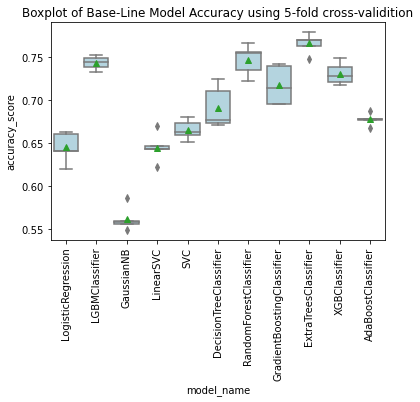

,model_name,fold_id,accuracy_score
0,LogisticRegression,0,0.619469
1,LogisticRegression,1,0.640708
2,LogisticRegression,2,0.640708
3,LogisticRegression,3,0.661947
4,LogisticRegression,4,0.660177
5,LGBMClassifier,0,0.752212
6,LGBMClassifier,1,0.738053
7,LGBMClassifier,2,0.743363
8,LGBMClassifier,3,0.732743
9,LGBMClassifier,4,0.748673


In [42]:
from sklearn.model_selection import StratifiedKFold
def generate_baseline_results(models, X, y, metrics, cv=5, plot_results=False):
    #define K-fold:
    kfold = StratifiedKFold(cv, shuffle=True, random_state=3 )
    entries=[]
    for model in models:
        model_name=model.__class__.__name__
        scores = cross_val_score(model, X, y, scoring=metrics, cv=kfold)
        for fold_idx, score in enumerate(scores):
            entries.append((model_name, fold_idx, score))
    cv_df= pd.DataFrame(entries, columns=['model_name', 'fold_id', 'accuracy_score'])

    if plot_results:
        sns.boxplot(x='model_name', y='accuracy_score', data=cv_df, color='lightblue', showmeans=True)
        plt.title('Boxplot of Base-Line Model Accuracy using 5-fold cross-validition')
        plt.xticks(rotation=90)
        plt.show()

    return cv_df
generate_baseline_results(models, X, y, metrics='accuracy', cv=5, plot_results=True)

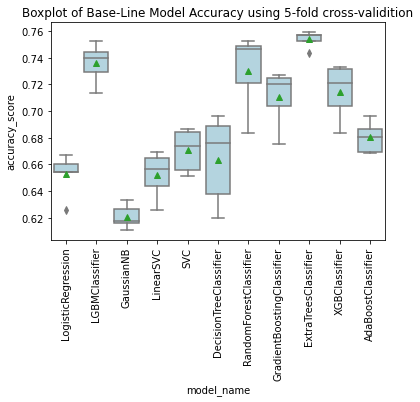

,model_name,fold_id,accuracy_score
0,LogisticRegression,0,0.667377
1,LogisticRegression,1,0.654584
2,LogisticRegression,2,0.654584
3,LogisticRegression,3,0.660256
4,LogisticRegression,4,0.626068
5,LGBMClassifier,0,0.729211
6,LGBMClassifier,1,0.744136
7,LGBMClassifier,2,0.739872
8,LGBMClassifier,3,0.752137
9,LGBMClassifier,4,0.713675


In [43]:
generate_baseline_results(models, X1, y1, metrics='accuracy', cv=5, plot_results=True)

In [44]:
from sklearn.metrics import make_scorer, cohen_kappa_score
def generate_baseline_results(models, X, y, metrics, cv=5, plot_results=False):
    # Define K-fold:
    kfold = StratifiedKFold(cv, shuffle=True, random_state=3)
    entries = []
    for model in models:
        model_name = model.__class__.__name__
        scores = {}
        for metric in metrics:
            score = cross_val_score(model, X, y, scoring=metric, cv=kfold)
            scores[metric] = score.mean()
        entries.append((model_name, scores))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'scores'])

    # Summarize result
    baseline_results = pd.concat([cv_df['model_name'], cv_df['scores'].apply(pd.Series)], axis=1)
    baseline_results.set_index('model_name', inplace=True)

    return baseline_results
metrics = ['accuracy', 'recall', 'f1', 'precision']
metrics.append(make_scorer(cohen_kappa_score))
generate_baseline_results(models, X, y, metrics, cv=5, plot_results=False)

,accuracy,recall,f1,precision,make_scorer(cohen_kappa_score)
model_name,,,,,
LogisticRegression,0.644602,0.763354,0.710002,0.663711,0.256835
LGBMClassifier,0.743009,0.819876,0.784215,0.752191,0.467887
GaussianNB,0.561416,0.449689,0.537583,0.673978,0.151006
LinearSVC,0.644248,0.759006,0.708662,0.664657,0.257061
SVC,0.664779,0.850311,0.743035,0.659910,0.282429
DecisionTreeClassifier,0.690619,0.725466,0.727197,0.729794,0.369784
RandomForestClassifier,0.746549,0.828571,0.788403,0.752606,0.474178
GradientBoostingClassifier,0.717168,0.832919,0.770475,0.717054,0.407361
ExtraTreesClassifier,0.765664,0.813043,0.798022,0.783902,0.519136


In [45]:
generate_baseline_results(models, X1, y1, metrics, cv=5, plot_results=False)

,accuracy,recall,f1,precision,make_scorer(cohen_kappa_score)
model_name,,,,,
LogisticRegression,0.652574,0.835277,0.739518,0.663566,0.237892
LGBMClassifier,0.735806,0.836713,0.788965,0.746763,0.438670
GaussianNB,0.620993,0.787571,0.710464,0.647935,0.176159
LinearSVC,0.652150,0.828784,0.737742,0.664894,0.239173
SVC,0.670494,0.885847,0.760599,0.666537,0.264692
DecisionTreeClassifier,0.663674,0.713159,0.714577,0.716236,0.305189
RandomForestClassifier,0.730250,0.847559,0.787672,0.735878,0.422788
GradientBoostingClassifier,0.710190,0.862722,0.778607,0.709664,0.370368
ExtraTreesClassifier,0.753730,0.820829,0.797358,0.775762,0.484041


Nhìn chung, model ExtraTreesClassifier có các tỉ lệ chiếm phần lớn cao nhất nên chúng tôi sẽ dựa vào mô hình này để phán đoán ra các doanh nghiệp có chi trả cổ tức hay không